In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_auc_score,precision_score, recall_score, f1_score, balanced_accuracy_score)
from boruta import BorutaPy
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt


Function to print confusion matrix metrics

In [11]:
def print_confusion_metric(y_true, y_pred, model_name="Model"):
    """
    Prints a table containing class-specific metrics for each class:
      Sensitivity, Specificity, Precision, Recall, F1, and Balanced Accuracy.
    Columns represent classes.
    
    If y_pred is a probability array, it is converted to discrete predictions
    by taking the argmax along axis=1.
    
    Parameters
    ----------
    y_true : array-like or pd.Series
        True labels.
    y_pred : array-like, pd.Series, or a probability array
        Predicted labels or probabilities.
    model_name : str
        Name of the model for display purposes.
    """
    # Convert probability predictions to discrete predictions if needed.
    if isinstance(y_pred, np.ndarray) and y_pred.ndim > 1:
        y_pred = np.argmax(y_pred, axis=1)
    
    # Convert y_true and y_pred to numeric arrays if they are categorical.
    if hasattr(y_true, 'cat'):
        y_true_numeric = y_true.cat.codes.values
    else:
        y_true_numeric = np.array(y_true, dtype=int)
    
    if hasattr(y_pred, 'cat'):
        y_pred_numeric = y_pred.cat.codes.values
    else:
        y_pred_numeric = np.array(y_pred, dtype=int)
    
    # Identify all classes (sorted for consistency)
    classes = np.unique(y_true_numeric)
    n_classes = len(classes)
    
    # Compute confusion matrix (used internally for specificity)
    cm = confusion_matrix(y_true_numeric, y_pred_numeric, labels=classes)
    
    # Compute class-wise metrics.
    sensitivity_vals = recall_score(y_true_numeric, y_pred_numeric, labels=classes, average=None, zero_division=0)
    precision_vals   = precision_score(y_true_numeric, y_pred_numeric, labels=classes, average=None, zero_division=0)
    f1_vals          = f1_score(y_true_numeric, y_pred_numeric, labels=classes, average=None, zero_division=0)
    
    # Compute specificity for each class from the confusion matrix.
    specificity_vals = []
    for i in range(n_classes):
        TP = cm[i, i]
        FN = np.sum(cm[i, :]) - TP
        FP = np.sum(cm[:, i]) - TP
        TN = np.sum(cm) - (TP + FP + FN)
        spec = TN / (TN + FP) if (TN + FP) != 0 else 0
        specificity_vals.append(spec)
    
    # Compute balanced accuracy (average of sensitivity and specificity)
    balanced_acc_vals = (sensitivity_vals + np.array(specificity_vals)) / 2
    
    # Build a DataFrame of metrics.
    row_labels = ["Sensitivity", "Specificity", "Precision", "Recall", "F1", "Balanced Accuracy"]
    col_labels = [f"Class {c}" for c in classes]
    
    data = np.array([
        np.round(sensitivity_vals, 2),
        np.round(specificity_vals, 2),
        np.round(precision_vals, 2),
        np.round(sensitivity_vals, 2),  # Recall is the same as Sensitivity.
        np.round(f1_vals, 2),
        np.round(balanced_acc_vals, 2)
    ])
    
    df_result = pd.DataFrame(data, index=row_labels, columns=col_labels)
    
    print(f"\n=== {model_name} ===")
    print("Class-specific Metrics:")
    print(df_result)

1. Data Loading and Cleaning

In [3]:
# Reading the data file
df = pd.read_csv("arrhythmia.data", header=None)
df.rename(columns={df.columns[-1]: 'Y'}, inplace=True)
#df.to_csv("arrhythmia.csv", index=False)

# Replace "?" with NaN
df.replace("?", np.nan, inplace=True)

# Data Cleaning:
# Remove rows where Y is in rare labels: 7,8,14,15,16
rare_lbl = [7, 8, 14, 15, 16]
df = df[~df['Y'].isin(rare_lbl)]

# Remove columns with only one unique value
df = df.loc[:, df.nunique() > 1]

# Count missing values per column and remove columns with more than 15 missing values
missing_counts = df.isna().sum()
df = df.loc[:, missing_counts <= 15]

# Convert non-numeric columns to numeric (if possible)
for col in df.columns:
    if not np.issubdtype(df[col].dtype, np.number):
        df[col] = pd.to_numeric(df[col], errors='coerce')

 2. Missing Value Imputation and Class Merging

In [4]:
# Impute missing values for specific angle columns with the column mean
for col in ['QRST_angle', 'T_angle', 'P_angle']:
    if col in df.columns:
        df[col].fillna(df[col].mean(), inplace=True)

# Merging classes:
# Merge class 4 into class 3
df.loc[df['Y'] == 4, 'Y'] = 3

# Merge classes 5 and 6 into 4
df.loc[df['Y'].isin([5, 6]), 'Y'] = 4

# Merge classes 9 and 10 into 5
df.loc[df['Y'].isin([9, 10]), 'Y'] = 5

# Convert Y to a categorical variable
df['Y'] = df['Y'].astype('category')

 3. Scaling the Data

In [5]:
# Scale all features except Y using StandardScaler
features = df.drop('Y', axis=1)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
df_scaled = pd.DataFrame(features_scaled, columns=features.columns)
df_scaled['Y'] = df['Y'].values  # append target variable

4. Splitting Data into Training and Test Sets

In [6]:
X = df_scaled.drop('Y', axis=1)
y = df_scaled['Y']

# Stratified split to keep class proportions; 75% training, 25% testing.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=123, stratify=y
)
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

5. Boruta Feature Selection

In [7]:
# BorutaPy requires the target as integers
y_train_codes = y_train.cat.codes.values

# Initialize a RandomForestClassifier (used by Boruta)
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=123)

# Initialize Boruta feature selector
feat_selector = BorutaPy(rf, n_estimators='auto', random_state=123)

# Fit Boruta on training data
feat_selector.fit(X_train.values, y_train_codes)

# Get selected feature names
selected_features = X_train.columns[feat_selector.support_].tolist()
print("Selected features by Boruta:", selected_features)

# Create new train and test sets with only the selected features
X_train_boruta = X_train[selected_features]
X_test_boruta = X_test[selected_features]

# For convenience, attach the target variable back into new DataFrames
df_train_boruta = X_train_boruta.copy()
df_train_boruta['Y'] = y_train
df_test_boruta = X_test_boruta.copy()
df_test_boruta['Y'] = y_test

Selected features by Boruta: [4, 6, 10, 14, 75, 89, 90, 92, 112, 113, 116, 166, 170, 171, 176, 178, 180, 196, 210, 216, 219, 223, 227, 229, 237, 239, 241, 242, 246, 248, 249, 251, 256, 259, 266, 268, 276, 278]


6. Linear Discriminant Analysis (LDA)

In [12]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_boruta, y_train)
pred_lda = lda.predict(X_test_boruta)
# For multiclass AUC, use the predicted probabilities and convert categories to codes.
pred_lda_proba = lda.predict_proba(X_test_boruta)
auc_lda = roc_auc_score(y_test.cat.codes, pred_lda_proba, multi_class='ovr')
print_confusion_metric(y_test, pred_lda, model_name="LDA")
print("LDA Multiclass AUC:", auc_lda)


=== LDA ===
Class-specific Metrics:
                   Class 0  Class 1  Class 2  Class 3  Class 4
Sensitivity            0.0     0.27     0.25     0.11     0.07
Specificity            1.0     0.19     0.89     0.90     0.98
Precision              0.0     0.04     0.18     0.11     0.33
Recall                 0.0     0.27     0.25     0.11     0.07
F1                     0.0     0.08     0.21     0.11     0.11
Balanced Accuracy      0.5     0.23     0.57     0.51     0.52
LDA Multiclass AUC: 0.8541637293774986


7. Random Forest

In [13]:
# Define parameter grid: 'n_estimators' (like ntree) and 'max_features' (like mtry)
param_grid_rf = {
    'n_estimators': [700, 1000, 2000],
    'max_features': [4, 8, 12, 16]
}

rf_model = RandomForestClassifier(random_state=123)
rf_search = RandomizedSearchCV(rf_model, param_distributions=param_grid_rf, cv=5, n_iter=10, random_state=123, n_jobs=-1)
rf_search.fit(X_train_boruta, y_train)
pred_rf = rf_search.predict(X_test_boruta)
accuracy_rf = accuracy_score(y_test, pred_rf)
print_confusion_metric(y_test, pred_rf, model_name="Random Forest")
print("Random Forest Accuracy:", accuracy_rf)


=== Random Forest ===
Class-specific Metrics:
                   Class 0  Class 1  Class 2  Class 3  Class 4
Sensitivity            0.0     0.27     0.25     0.00     0.00
Specificity            1.0     0.23     0.89     0.92     0.90
Precision              0.0     0.05     0.18     0.00     0.00
Recall                 0.0     0.27     0.25     0.00     0.00
F1                     0.0     0.08     0.21     0.00     0.00
Balanced Accuracy      0.5     0.25     0.57     0.46     0.45
Random Forest Accuracy: 0.8461538461538461


8. Support Vector Machines (RBF and Linear)

In [14]:
# SVM with RBF kernel
param_grid_svm_rbf = {
    'C': [2**i for i in range(-5, 6)],
    'gamma': [2**i for i in range(-7, 5)]
}
svm_rbf = SVC(kernel='rbf', probability=True, random_state=123)
svm_rbf_search = GridSearchCV(svm_rbf, param_grid=param_grid_svm_rbf, cv=5, n_jobs=-1)
svm_rbf_search.fit(X_train_boruta, y_train)
pred_svm_rbf = svm_rbf_search.predict(X_test_boruta)
pred_svm_rbf_proba = svm_rbf_search.predict_proba(X_test_boruta)
auc_svm_rbf = roc_auc_score(y_test.cat.codes, pred_svm_rbf_proba, multi_class='ovr')
print_confusion_metric(y_test, pred_svm_rbf, model_name="SVM RBF")
print("SVM RBF Multiclass AUC:", auc_svm_rbf)

# SVM with Linear kernel
param_grid_svm_linear = {
    'C': [2**i for i in range(-5, 16)]
}
svm_linear = SVC(kernel='linear', probability=True, random_state=123)
svm_linear_search = GridSearchCV(svm_linear, param_grid=param_grid_svm_linear, cv=5, n_jobs=-1)
svm_linear_search.fit(X_train_boruta, y_train)
pred_svm_linear = svm_linear_search.predict(X_test_boruta)
print_confusion_metric(y_test, pred_svm_linear, model_name="SVM Linear")


=== SVM RBF ===
Class-specific Metrics:
                   Class 0  Class 1  Class 2  Class 3  Class 4
Sensitivity            0.0     0.09     0.12     0.00     0.07
Specificity            1.0     0.23     0.83     0.90     0.94
Precision              0.0     0.02     0.07     0.00     0.17
Recall                 0.0     0.09     0.12     0.00     0.07
F1                     0.0     0.03     0.09     0.00     0.10
Balanced Accuracy      0.5     0.16     0.48     0.45     0.50
SVM RBF Multiclass AUC: 0.9227288937958944

=== SVM Linear ===
Class-specific Metrics:
                   Class 0  Class 1  Class 2  Class 3  Class 4
Sensitivity            0.0     0.18     0.12     0.11      0.0
Specificity            1.0     0.16     0.85     0.92      1.0
Precision              0.0     0.03     0.07     0.12      0.0
Recall                 0.0     0.18     0.12     0.11      0.0
F1                     0.0     0.05     0.09     0.12      0.0
Balanced Accuracy      0.5     0.17     0.49     0.51

9. Decision Trees


=== Decision Tree ===
Class-specific Metrics:
                   Class 0  Class 1  Class 2  Class 3  Class 4
Sensitivity            0.0     0.18     0.00     0.00     0.07
Specificity            1.0     0.15     0.88     0.96     0.92
Precision              0.0     0.03     0.00     0.00     0.12
Recall                 0.0     0.18     0.00     0.00     0.07
F1                     0.0     0.05     0.00     0.00     0.09
Balanced Accuracy      0.5     0.17     0.44     0.48     0.49
Decision Tree Accuracy: 0.7596153846153846


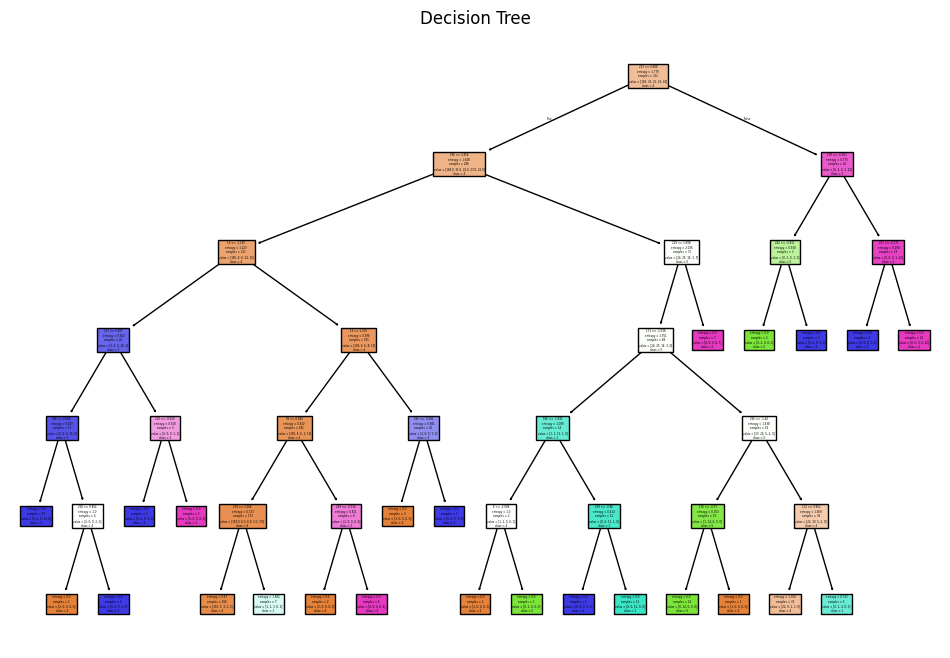

In [15]:
# Using 'entropy' to mimic information gain (split = "information" in R)
dtree = DecisionTreeClassifier(criterion='entropy', random_state=123)
# A simple grid search over max_depth (tuneLength=40 in R roughly corresponds to exploring a range)
dtree_search = GridSearchCV(dtree, param_grid={'max_depth': range(1, 21)}, cv=5, n_jobs=-1)
dtree_search.fit(X_train_boruta, y_train)
pred_dtree = dtree_search.predict(X_test_boruta)
accuracy_dtree = accuracy_score(y_test, pred_dtree)

print_confusion_metric(y_test, pred_dtree, model_name="Decision Tree")
print("Decision Tree Accuracy:", accuracy_dtree)

# Plot the best decision tree
plt.figure(figsize=(12, 8))
plot_tree(dtree_search.best_estimator_, feature_names=X_train_boruta.columns, 
          class_names=[str(cls) for cls in y.unique()], filled=True)
plt.title("Decision Tree")
plt.show()

10. XGBoost

In [16]:
# For XGBoost, convert Y to 0-indexed integers
y_train_xgb = y_train.cat.codes.copy()
y_test_xgb = y_test.cat.codes.copy()

xgb_model = xgb.XGBClassifier(
    objective='multi:softmax', 
    num_class=len(y_train.unique()),
    eval_metric='merror',
    random_state=123, 
    n_jobs=-1
)
# Define a parameter grid similar to R's tuning parameters.
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3], # 'eta' in R
    'max_depth': list(range(3, 11)),
    'n_estimators': list(range(3, 21)), # 'nrounds' in R
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'reg_lambda': [0, 1, 2], # 'lambda' in R
    'gamma': [0]
}

xgb_search = RandomizedSearchCV(xgb_model, param_distributions=param_grid_xgb, cv=5, n_iter=5, random_state=123, n_jobs=-1)
xgb_search.fit(X_train_boruta, y_train_xgb)
xgb_pred = xgb_search.predict(X_test_boruta)

print_confusion_metric(y_test_xgb, xgb_pred, model_name="XGBoost")


=== XGBoost ===
Class-specific Metrics:
                   Class 0  Class 1  Class 2  Class 3  Class 4
Sensitivity           0.90     0.55     0.88     0.89     0.60
Specificity           0.81     0.96     0.98     0.98     0.97
Precision             0.87     0.60     0.78     0.80     0.75
Recall                0.90     0.55     0.88     0.89     0.60
F1                    0.89     0.57     0.82     0.84     0.67
Balanced Accuracy     0.86     0.75     0.93     0.93     0.78


11. K-Nearest Neighbors (KNN)

In [17]:
knn = KNeighborsClassifier()
param_grid_knn = {
    'n_neighbors': list(range(1, 21))
}
knn_search = GridSearchCV(knn, param_grid=param_grid_knn, cv=5, n_jobs=-1)
knn_search.fit(X_train_boruta, y_train)
pred_knn = knn_search.predict(X_test_boruta)
accuracy_knn = accuracy_score(y_test, pred_knn)
print("KNN Accuracy:", accuracy_knn)

# Print class-specific metrics using the unified function.
print_confusion_metric(y_test, pred_knn, model_name="KNN")

# For AUC calculation, get predicted probabilities.
pred_knn_proba = knn_search.predict_proba(X_test_boruta)
auc_knn = roc_auc_score(y_test.cat.codes, pred_knn_proba, multi_class='ovr')
print("KNN Multiclass AUC:", auc_knn)

KNN Accuracy: 0.7307692307692307

=== KNN ===
Class-specific Metrics:
                   Class 0  Class 1  Class 2  Class 3  Class 4
Sensitivity            0.0     0.45     0.12     0.00     0.00
Specificity            1.0     0.20     0.93     0.89     0.93
Precision              0.0     0.07     0.14     0.00     0.00
Recall                 0.0     0.45     0.12     0.00     0.00
F1                     0.0     0.12     0.13     0.00     0.00
Balanced Accuracy      0.5     0.33     0.53     0.45     0.47
KNN Multiclass AUC: 0.7493340220804832
